In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

# Data preparation

In [3]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name
    for label_idx, class_name in enumerate(
        sorted(os.listdir(train_dir))
    )
}

X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [4]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

class ScenesDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [5]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)
test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


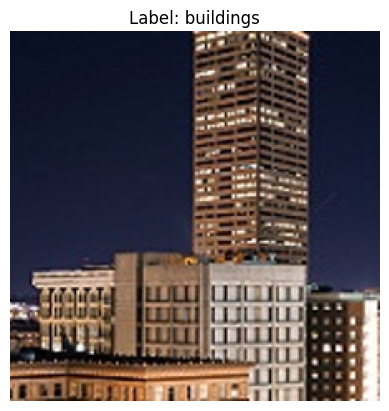

In [6]:
# print sample data
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.axis('off')
plt.title("Label: " + classes[label.item()])
plt.show()

# DenseNet modeling

In [7]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], 1)

        return x
    
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [8]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
n_classes = len(list(classes.keys()))
print(f"n_classes: {n_classes}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

model = DenseNet([6, 12, 24, 16], growth_rate=32, num_classes=n_classes).to(device)
model

n_classes: 6
device: cuda


DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense_blocks): ModuleList(
    (0): DenseBlock(
      (block): Sequential(
        (0): BottleneckBlock(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (relu): ReLU()
        )
        (1): BottleneckBlock(
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [10]:
model.eval()

dummy_tensor = torch.rand(1, 3, 224, 224).to(device)

with torch.no_grad():
    dummy_output = model(dummy_tensor)

print(f"Output shape: {dummy_output.shape}")
print(f"Output: {dummy_output}")

Output shape: torch.Size([1, 6])
Output: tensor([[-0.0016, -0.0064, -0.0101, -0.0103, -0.0286,  0.0289]],
       device='cuda:0')


# Model training

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss = sum(losses) / len(losses)
        acc = correct / total

    return loss, acc

In [12]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [13]:
lr = 1e-2
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

In [ ]:
# save model
model_dir = 'model'
model_name = 'densenet_scenes.pth'
model_path = os.path.join(model_dir, model_name)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(model.state_dict(), model_path)
print(f"Model is saved at {model_path}")

# Evaluation

In [ ]:
# plot losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)